In [45]:
# from google.colab import drive
# drive.mount('/content/drive')

In [46]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("parulpandey/palmer-archipelago-antarctica-penguin-data")
folder_path = path
print(os.listdir(folder_path))

csv_path = os.path.join(folder_path, 'penguins_size.csv') # เลือก penguins_size.csv
penguins = pd.read_csv(csv_path)

penguins.head()

['penguins_lter.csv', 'penguins_size.csv']


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [47]:
print(f"{penguins.isna().any()}")
# .isna() returns a DataFrame of the same shape as 'penguins',
# with True where the values are NaN (missing) and False otherwise.
# .any() applied on this DataFrame defaults to axis=0 (column-wise),
# so it returns a Series of booleans indicating whether each column
# contains at least one NaN value.
# The print will show which columns have any missing values.

print("-"*50)
# Prints a line of 50 dashes as a separator for better readability.

print(f"{penguins.isna().sum()}")
# .sum() here sums up the True values in each column (since True == 1),
# so it counts the total number of NaN values per column.
# The print will show how many missing values each column has.


species              False
island               False
culmen_length_mm      True
culmen_depth_mm       True
flipper_length_mm     True
body_mass_g           True
sex                   True
dtype: bool
--------------------------------------------------
species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64


In [48]:
print(penguins.shape)
penguins[penguins.isna().any(axis=1)]

(344, 7)


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


In [49]:
penguins_clean = penguins.copy()
penguins_clean.dropna(inplace=True)
print(penguins_clean.shape)

(334, 7)


Load a Kaggle dataset with data about **penguin species**, eliminating by default the instances that contain missing values (for this, we use the *dropna()* function from *pandas* library).

In [50]:
# @title Target is to classifiy the species (3 classes) of penguins from feature artibutes
penguins_clean['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [51]:
penguins_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Data preparation, training and predictions. We will use **k=3**, so that each prediction will be based in the three closest training (labeled) instances to each test instance.

In [53]:
# Separate predictor variables from class label
# For predictor attributes, we only keep numerical and exclude categorical ones
X = penguins_clean.select_dtypes(exclude=['object'])
y = penguins_clean.species

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

In [54]:
# @title k-Nearest Neighbors from scratch
import math
import numpy as np

# Euclidean distance
def euclidean(x, y):
  return np.sqrt(np.sum((x-y)**2))

# Locate the most similar neighbors
def get_neighbors(test_row, X_train, y_train, n_neighbors):
	distances = list()
	for (train_row, train_class) in zip(X_train, y_train):
		dist = euclidean(train_row, test_row)
		distances.append((dist, train_class))

  # Ex : [(0.75, 'A'), (1.41, 'A'), (2.23, 'B')]
	distances.sort(key=lambda tple: tple[0])
	neighbors = list()
	for i in range(n_neighbors):
		neighbors.append(distances[i][1])

  # Ex : ['A', 'A', 'B']
	return neighbors

# Get the modal (most common) value in the passed array
# arr = ['A', 'A', 'B']
# vals = ['A', 'B'], cnts = [2, 1]
def mode(arr):
  vals, cnts = np.unique(arr, return_counts=True)
  mode = vals[cnts.argmax()]

  return mode

# Make predictions
def predict(X_test, X_train, y_train, n_neighbors):
  preds = list()
  for test_row in X_test:
    neighbors = get_neighbors(test_row, X_train, y_train, n_neighbors)
    modal = mode(neighbors)
    preds.append(modal)

  return np.array(preds)

# Get accuracy
def accuracy(y_test, preds):
  return (preds == y_test).mean()

In [55]:
knn_predict_scratch = predict(X_test.values, X_train.values, y_train.values, n_neighbors=1)
accuracy(knn_predict_scratch, y_test)

np.float64(0.7920792079207921)

In [56]:
knn_predict_scratch = predict(X_test.values, X_train.values, y_train.values, n_neighbors=2)
accuracy(knn_predict_scratch, y_test)

np.float64(0.7524752475247525)

In [57]:
knn_predict_scratch = predict(X_test.values, X_train.values, y_train.values, n_neighbors=3)
accuracy(knn_predict_scratch, y_test)

np.float64(0.7722772277227723)

In [58]:
knn_predict_scratch = predict(X_test.values, X_train.values, y_train.values, n_neighbors=4)
accuracy(knn_predict_scratch, y_test)

np.float64(0.7722772277227723)

In [59]:
# @title From Scikit-Learn API
from sklearn.neighbors import KNeighborsClassifier

**DO IT YOURSELF**: Try other settings for "k" and observe how this affects the classifier performance.

In [60]:
# Initialize a kNN classifier, with hyperparameter 'k=3'
knn_n3 = KNeighborsClassifier(n_neighbors=3)

# Training the "model": this may lead to confusion, because KNN is an instance-based algorithm, not model based.
# However, scikit-learn still requires using this method, because the "model"
# will be defined by the training instances themselves.
knn_n3.fit(X_train, y_train)

# Making predictions on test data
predictions_n3 = knn_n3.predict(X_test)

accuracy_score(y_test, predictions_n3)

0.7722772277227723

In [61]:
# 1 cluster assigned

knn_n1 = KNeighborsClassifier(n_neighbors=1)
knn_n1.fit(X_train, y_train)
predictions_n1 = knn_n1.predict(X_test)

accuracy_score(y_test, predictions_n1)

0.7920792079207921

In [62]:
# 2 cluster assigned

knn_n2 = KNeighborsClassifier(n_neighbors=2)
knn_n2.fit(X_train, y_train)
predictions_n2 = knn_n2.predict(X_test)

accuracy_score(y_test, predictions_n2)

0.7524752475247525

In [63]:
# 4 cluster assigned

knn_n4 = KNeighborsClassifier(n_neighbors=4)
knn_n4.fit(X_train, y_train)
predictions_n4 = knn_n4.predict(X_test)

accuracy_score(y_test, predictions_n4)

0.7722772277227723

How can we find the best k value? We can calculate the accuracy of the prediction for multiple k values and see which is the best.

In [64]:
nK = 20
mean_acc = list()
for n in range(1, nK+1):
  knn_mul = KNeighborsClassifier(n_neighbors=n)
  knn_mul.fit(X_train, y_train)
  predictions_mul = knn_mul.predict(X_test)
  mean_acc.append(accuracy_score(y_test, predictions_mul))

mean_acc

[0.7920792079207921,
 0.7524752475247525,
 0.7722772277227723,
 0.7722772277227723,
 0.7227722772277227,
 0.7326732673267327,
 0.7227722772277227,
 0.7623762376237624,
 0.7326732673267327,
 0.7326732673267327,
 0.7623762376237624,
 0.7524752475247525,
 0.7623762376237624,
 0.7524752475247525,
 0.7623762376237624,
 0.7326732673267327,
 0.7128712871287128,
 0.7326732673267327,
 0.7425742574257426,
 0.7425742574257426]

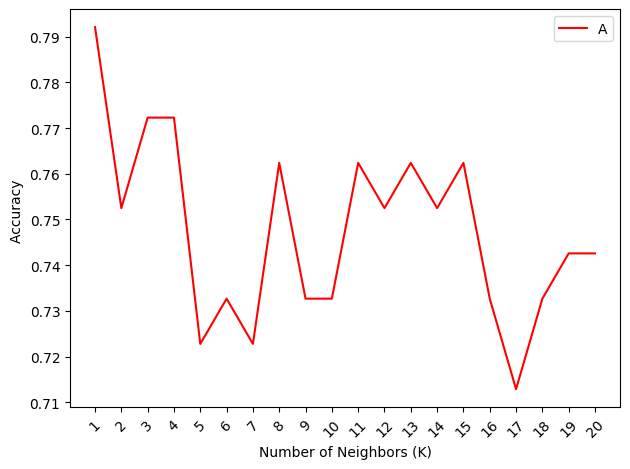

In [65]:
import matplotlib.pyplot as plt

plt.plot(range(1, nK+1), mean_acc, 'r')
plt.xticks(range(1, nK+1), fontsize=10, rotation=45)
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [66]:
# @title Visualization (Decision Boundaries for K-Nearest Neighbors)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# For demonstrational purposes, we are going take two features
def plot_knn_two_feature_regions(X, y, n_neighbors=3, resolution=0.02):
  # setup marker generator and color map
  colors = ('orange', 'cornflowerblue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  X = X.loc[:, ['culmen_length_mm', 'culmen_depth_mm']]
  le = LabelEncoder()
  y = le.fit_transform(y) # plot does not accept string labels. We need to transform them into numbers
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

  x1_min, x1_max = X_test.iloc[:, 0].min() - 1, X_test.iloc[:, 0].max() + 1
  x2_min, x2_max = X_test.iloc[:, 1].min() - 1, X_test.iloc[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
  print(f"Feature 1 {xx1.shape} | Feature 2 {xx2.shape}")

  '''
  xx1 = [[1, 2, 3],    → แถวที่ 1: ค่าของ feature 1
        [1, 2, 3],     → แถวที่ 2: เหมือนเดิม
        [1, 2, 3]]     → ทุกแถว = x-axis เดิมซ้ำ

  xx2 = [[10, 10, 10], → คอลัมน์ที่ 1: y = 10 ซ้ำ
        [20, 20, 20],
        [30, 30, 30]]  → y เพิ่มขึ้นในแต่ละแถว
  '''

  '''
  [(1, 10), (2, 10), (3, 10),
  (1, 20), (2, 20), (3, 20),
  (1, 30), (2, 30), (3, 30)]

  '''

  # kNN prediction
  knn = KNeighborsClassifier(n_neighbors)
  knn.fit(X_train, y_train)
  Z = knn.predict(np.array([xx1.ravel(), xx2.ravel()]).T)

  # Put the result into a color plot
  Z = Z.reshape(xx1.shape)
  plt.figure()
  plt.pcolormesh(xx1, xx2, Z, cmap=cmap, shading='nearest')
  plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)

  # Plot the training points
  plt.scatter(X_test.iloc[:, 0],
            X_test.iloc[:, 1],
            c=y_test,
            cmap=cmap,
            edgecolor='k',
            s=20)

  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())
  plt.show()

  # Predict test set
  y_pred = knn.predict(X_test)

  # ⬅️ คำนวณ accuracy แล้วแสดงผล
  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy (K = {n_neighbors}) : {acc:.2f}")

Feature 1 (520, 1235) | Feature 2 (520, 1235)


C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


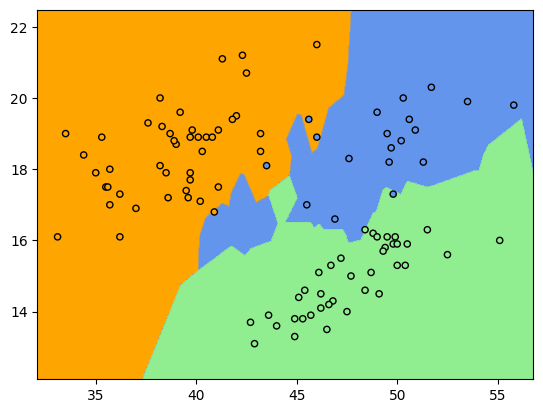

Accuracy (K = 1) : 0.94


In [67]:
plot_knn_two_feature_regions(X, y, n_neighbors=1)

Feature 1 (520, 1235) | Feature 2 (520, 1235)


C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


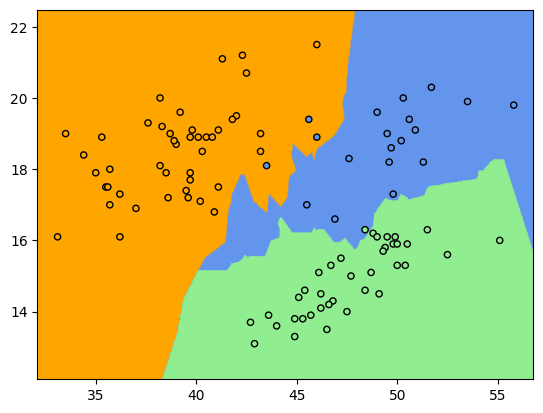

Accuracy (K = 2) : 0.96


In [68]:
plot_knn_two_feature_regions(X, y, n_neighbors=2)

Feature 1 (520, 1235) | Feature 2 (520, 1235)


C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


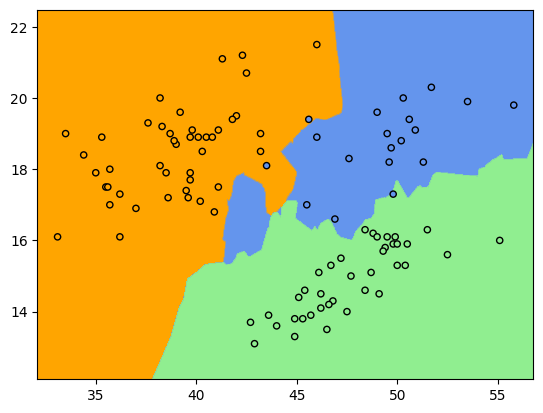

Accuracy (K = 3) : 0.97


In [69]:
plot_knn_two_feature_regions(X, y, n_neighbors=3)

Feature 1 (520, 1235) | Feature 2 (520, 1235)


C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


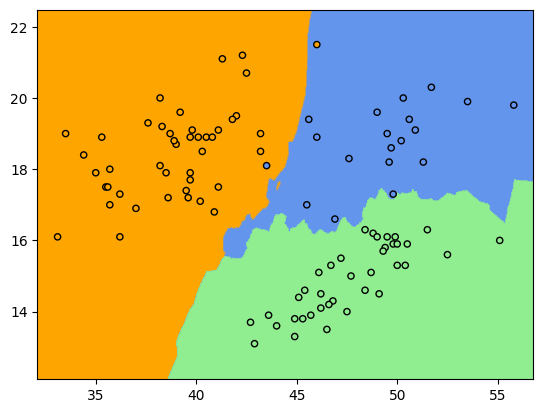

Accuracy (K = 10) : 0.98


In [70]:
plot_knn_two_feature_regions(X, y, n_neighbors=10)

---------
# Homework

ทำการใช้ kNN algorithm มา predict ข้อมูลใน Apple Quality Dataset ใน column ส่วนข้อมูล Quality (binary classification) แล้วหาผลลัพธ์ ดังนี้
  
1. ให้สร้าง train set และ test set จาก dataset ที่กำหนด โดยให้ test_size=0.3 และ random_state=42
2. ใช้ kNN algorithm โดยกำหนดค่า k ทั้งหมด 30 ค่า (1-30) และทำการ log accuracy ของแต่ละ k แสดงในรูปแบบของ line chart พร้อมทั้งระบุว่าค่า k ค่าใดที่ทำให้ model มี accuracy ที่สูงที่สุด (เลือก feature ทั้งหมด ยกเว้น A_id)

3. ทำการสร้าง Decision Boundaries โดยใช้ค่า k จากเลขท้ายของเลขประจำตัวนักศึกษา Ex 65010005 (k = 5),  65010030 (k = 10) โดยมีเงื่อนไขคือ
  - เลือก feature 2 feature ที่จะทำให้ค่า accuracy สูงที่สุด โดยเลือกจาก ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness',
       'Ripeness', 'Acidity']
  - ทำการแสดง Decision Boundaries และ accuracy ที่ได้
** guide C(n,r)

In [71]:
import kagglehub
import os

# Download latest version
folder_path = kagglehub.dataset_download("nelgiriyewithana/apple-quality")
print(os.listdir(folder_path)) # เลือก "['apple_quality.csv']"

csv_path = os.path.join(folder_path, 'apple_quality.csv')
apple = pd.read_csv(csv_path)

apple.head()

['apple_quality.csv']


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [72]:
print("Dataset shape:", apple.shape)
print("\nDataset info:")
print(apple.info())
print("\nTarget distribution:")
print(apple['Quality'].value_counts())
print("\nMissing values:")
print(apple.isnull().sum())

Dataset shape: (4001, 9)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB
None

Target distribution:
Quality
good    2004
bad     1996
Name: count, dtype: int64

Missing values:
A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64


In [73]:
# Clean the data - remove missing values
apple_clean = apple.dropna()
print(f"Dataset shape after cleaning: {apple_clean.shape}")

# Prepare features (X) and target (y)
# Exclude A_id as specified in the homework
X_apple = apple_clean.drop(['A_id', 'Quality'], axis=1)
y_apple = apple_clean['Quality']

# Convert Acidity to numeric (it seems to be object type)
X_apple['Acidity'] = pd.to_numeric(X_apple['Acidity'])

print(f"Features shape: {X_apple.shape}")
print(f"Features: {list(X_apple.columns)}")
print(f"Target classes: {y_apple.unique()}")

# Create train and test sets with test_size=0.3 and random_state=42
from sklearn.model_selection import train_test_split

X_train_apple, X_test_apple, y_train_apple, y_test_apple = train_test_split(
    X_apple, y_apple, test_size=0.3, random_state=42
)

print(f"\nTrain set size: {X_train_apple.shape[0]}")
print(f"Test set size: {X_test_apple.shape[0]}")
print(f"Train target distribution:\n{y_train_apple.value_counts()}")
print(f"Test target distribution:\n{y_test_apple.value_counts()}")

Dataset shape after cleaning: (4000, 9)
Features shape: (4000, 7)
Features: ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
Target classes: ['good' 'bad']

Train set size: 2800
Test set size: 1200
Train target distribution:
Quality
bad     1403
good    1397
Name: count, dtype: int64
Test target distribution:
Quality
good    607
bad     593
Name: count, dtype: int64


In [ ]:
# Test k-NN from scratch implementation with Apple Quality dataset
print("Testing k-NN from scratch with Apple Quality dataset:")
print("-" * 50)

# Helper function for accuracy calculation (from scratch implementation)
def calculate_accuracy(y_true, y_pred):
    return (y_pred == y_true).mean()

# Test with different k values using our scratch implementation
knn_predict_scratch_apple_1 = predict(X_test_apple.values, X_train_apple.values, y_train_apple.values, n_neighbors=1)
print(f"k=1 accuracy (from scratch): {calculate_accuracy(y_test_apple, knn_predict_scratch_apple_1):.4f}")

knn_predict_scratch_apple_2 = predict(X_test_apple.values, X_train_apple.values, y_train_apple.values, n_neighbors=2)
print(f"k=2 accuracy (from scratch): {calculate_accuracy(y_test_apple, knn_predict_scratch_apple_2):.4f}")

knn_predict_scratch_apple_3 = predict(X_test_apple.values, X_train_apple.values, y_train_apple.values, n_neighbors=3)
print(f"k=3 accuracy (from scratch): {calculate_accuracy(y_test_apple, knn_predict_scratch_apple_3):.4f}")

knn_predict_scratch_apple_4 = predict(X_test_apple.values, X_train_apple.values, y_train_apple.values, n_neighbors=4)
print(f"k=4 accuracy (from scratch): {calculate_accuracy(y_test_apple, knn_predict_scratch_apple_4):.4f}")

Testing k-NN from scratch with Apple Quality dataset:
--------------------------------------------------
k=1 accuracy (from scratch): 0.8883
k=1 accuracy (from scratch): 0.8883
k=2 accuracy (from scratch): 0.8592
k=2 accuracy (from scratch): 0.8592
k=3 accuracy (from scratch): 0.8917
k=3 accuracy (from scratch): 0.8917
k=4 accuracy (from scratch): 0.8783
k=4 accuracy (from scratch): 0.8783


In [ ]:
# From Scikit-Learn API
print("\n" + "="*50)
print("Testing with Scikit-Learn API:")
print("="*50)

# k=1
knn_apple_n1 = KNeighborsClassifier(n_neighbors=1)
knn_apple_n1.fit(X_train_apple, y_train_apple)
predictions_apple_n1 = knn_apple_n1.predict(X_test_apple)
print(f"k=1 accuracy (scikit-learn): {accuracy_score(y_test_apple, predictions_apple_n1):.4f}")

# k=2
knn_apple_n2 = KNeighborsClassifier(n_neighbors=2)
knn_apple_n2.fit(X_train_apple, y_train_apple)
predictions_apple_n2 = knn_apple_n2.predict(X_test_apple)
print(f"k=2 accuracy (scikit-learn): {accuracy_score(y_test_apple, predictions_apple_n2):.4f}")

# k=3
knn_apple_n3 = KNeighborsClassifier(n_neighbors=3)
knn_apple_n3.fit(X_train_apple, y_train_apple)
predictions_apple_n3 = knn_apple_n3.predict(X_test_apple)
print(f"k=3 accuracy (scikit-learn): {accuracy_score(y_test_apple, predictions_apple_n3):.4f}")

# k=4
knn_apple_n4 = KNeighborsClassifier(n_neighbors=4)
knn_apple_n4.fit(X_train_apple, y_train_apple)
predictions_apple_n4 = knn_apple_n4.predict(X_test_apple)
print(f"k=4 accuracy (scikit-learn): {accuracy_score(y_test_apple, predictions_apple_n4):.4f}")


Testing with Scikit-Learn API:
k=1 accuracy (scikit-learn): 0.8883
k=2 accuracy (scikit-learn): 0.8592
k=3 accuracy (scikit-learn): 0.8917
k=4 accuracy (scikit-learn): 0.8783


In [ ]:
# (Apple Quality Dataset)
nK_apple = 30
mean_acc_apple = list()
for n in range(1, nK_apple+1):
  knn_mul_apple = KNeighborsClassifier(n_neighbors=n)
  knn_mul_apple.fit(X_train_apple, y_train_apple)
  predictions_mul_apple = knn_mul_apple.predict(X_test_apple)
  mean_acc_apple.append(accuracy_score(y_test_apple, predictions_mul_apple))

# Display results
print("k-NN Accuracy for k values 1-30 (Apple Quality Dataset):")
print("k\tAccuracy")
print("-" * 20)
for i, acc in enumerate(mean_acc_apple, 1):
    print(f"{i}\t{acc:.4f}")

# Find the best k value
best_k_apple = mean_acc_apple.index(max(mean_acc_apple)) + 1
best_accuracy_apple = max(mean_acc_apple)

print(f"\nBest k value: {best_k_apple}")
print(f"Best accuracy: {best_accuracy_apple:.4f}")
print(f"All accuracy values: {mean_acc_apple}")

k-NN Accuracy for k values 1-30 (Apple Quality Dataset):
k	Accuracy
--------------------
1	0.8883
2	0.8592
3	0.8917
4	0.8783
5	0.8983
6	0.8833
7	0.9017
8	0.8975
9	0.9025
10	0.8925
11	0.9025
12	0.8892
13	0.8942
14	0.8908
15	0.9025
16	0.8950
17	0.9000
18	0.8908
19	0.9008
20	0.8950
21	0.8992
22	0.8950
23	0.8958
24	0.8925
25	0.8992
26	0.8875
27	0.8950
28	0.8900
29	0.8917
30	0.8883

Best k value: 9
Best accuracy: 0.9025
All accuracy values: [0.8883333333333333, 0.8591666666666666, 0.8916666666666667, 0.8783333333333333, 0.8983333333333333, 0.8833333333333333, 0.9016666666666666, 0.8975, 0.9025, 0.8925, 0.9025, 0.8891666666666667, 0.8941666666666667, 0.8908333333333334, 0.9025, 0.895, 0.9, 0.8908333333333334, 0.9008333333333334, 0.895, 0.8991666666666667, 0.895, 0.8958333333333334, 0.8925, 0.8991666666666667, 0.8875, 0.895, 0.89, 0.8916666666666667, 0.8883333333333333]


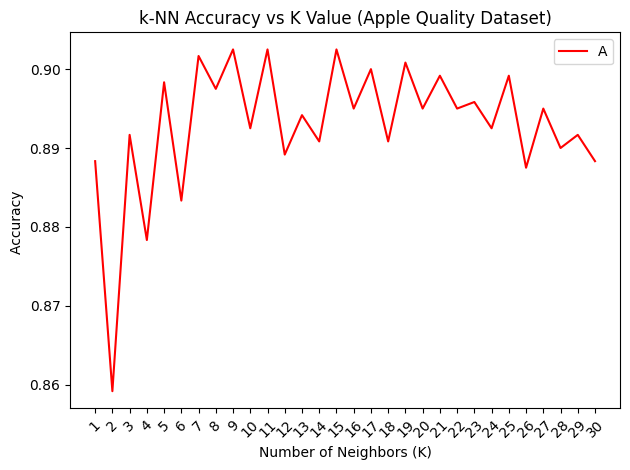


สรุป Part 2:
ค่า k ที่ทำให้ model มี accuracy สูงที่สุด: k = 9
ค่า accuracy สูงสุด: 0.9025 (90.25%)


In [ ]:
# Plotting accuracy vs k
import matplotlib.pyplot as plt

plt.plot(range(1, nK_apple+1), mean_acc_apple, 'r')
plt.xticks(range(1, nK_apple+1), fontsize=10, rotation=45)
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.title('k-NN Accuracy vs K Value (Apple Quality Dataset)')
plt.tight_layout()
plt.show()

print(f"\nสรุป Part 2:")
print(f"ค่า k ที่ทำให้ model มี accuracy สูงที่สุด: k = {best_k_apple}")
print(f"ค่า accuracy สูงสุด: {best_accuracy_apple:.4f} ({best_accuracy_apple*100:.2f}%)")

In [ ]:
# Find the best 2 features using combinations C(n,r) where n=7, r=2
from itertools import combinations

# Available features as specified
available_features = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
student_k = 1  # student ID 65010421

print(f"จำนวนการรวมกันของ features 2 ตัว: C(7,2) = {len(list(combinations(available_features, 2)))}")

# Test all combinations of 2 features
feature_combinations = list(combinations(available_features, 2))
combination_results = []

print("Features\t\t\t\tAccuracy")
print("-" * 60)

for i, (feat1, feat2) in enumerate(feature_combinations):
    # Create subset with only these 2 features
    X_train_subset = X_train_apple[[feat1, feat2]]
    X_test_subset = X_test_apple[[feat1, feat2]]
    
    # Train k-NN with k=1
    knn = KNeighborsClassifier(n_neighbors=student_k)
    knn.fit(X_train_subset, y_train_apple)
    predictions = knn.predict(X_test_subset)
    accuracy = accuracy_score(y_test_apple, predictions)
    
    combination_results.append({
        'features': (feat1, feat2),
        'accuracy': accuracy
    })
    
    print(f"{feat1:<12} + {feat2:<12}\t{accuracy:.4f}")

# Find the best combination
best_combination = max(combination_results, key=lambda x: x['accuracy'])
best_features = best_combination['features']
best_feature_accuracy = best_combination['accuracy']

print(f"\nBest feature combination: {best_features[0]} + {best_features[1]}")
print(f"Best accuracy with 2 features: {best_feature_accuracy:.4f} ({best_feature_accuracy*100:.2f}%)")

จำนวนการรวมกันของ features 2 ตัว: C(7,2) = 21
Features				Accuracy
------------------------------------------------------------
Size         + Weight      	0.5375
Size         + Sweetness   	0.5883
Size         + Crunchiness 	0.5550
Size         + Juiciness   	0.5892
Size         + Ripeness    	0.6217
Size         + Acidity     	0.5525
Weight       + Sweetness   	0.5600
Weight       + Crunchiness 	0.5408
Weight       + Juiciness   	0.5708
Weight       + Ripeness    	0.5650
Weight       + Acidity     	0.5817
Sweetness    + Crunchiness 	0.5625
Sweetness    + Juiciness   	0.5617
Sweetness    + Ripeness    	0.5992
Sweetness    + Acidity     	0.5317
Crunchiness  + Juiciness   	0.6125
Crunchiness  + Ripeness    	0.5683
Crunchiness  + Acidity     	0.5075
Juiciness    + Ripeness    	0.6192
Juiciness    + Acidity     	0.5692
Ripeness     + Acidity     	0.5425

Best feature combination: Size + Ripeness
Best accuracy with 2 features: 0.6217 (62.17%)


In [79]:
# Visualization (Decision Boundaries for K-Nearest Neighbors) - Apple Quality Dataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# For demonstrational purposes, we are going take two features (same structure as penguin example)
def plot_apple_knn_two_feature_regions(X, y, feature1, feature2, n_neighbors=1, resolution=0.02):
  # setup marker generator and color map
  colors = ('orange', 'cornflowerblue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  X = X.loc[:, [feature1, feature2]]
  le = LabelEncoder()
  y = le.fit_transform(y) # plot does not accept string labels. We need to transform them into numbers
  X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(X, y, test_size=.3, random_state=42)

  x1_min, x1_max = X_test_viz.iloc[:, 0].min() - 1, X_test_viz.iloc[:, 0].max() + 1
  x2_min, x2_max = X_test_viz.iloc[:, 1].min() - 1, X_test_viz.iloc[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
  print(f"Feature 1 ({feature1}) {xx1.shape} | Feature 2 ({feature2}) {xx2.shape}")

  '''
  xx1 = [[1, 2, 3],    → แถวที่ 1: ค่าของ feature 1
        [1, 2, 3],     → แถวที่ 2: เหมือนเดิม
        [1, 2, 3]]     → ทุกแถว = x-axis เดิมซ้ำ

  xx2 = [[10, 10, 10], → คอลัมน์ที่ 1: y = 10 ซ้ำ
        [20, 20, 20],
        [30, 30, 30]]  → y เพิ่มขึ้นในแต่ละแถว
  '''

  '''
  [(1, 10), (2, 10), (3, 10),
  (1, 20), (2, 20), (3, 20),
  (1, 30), (2, 30), (3, 30)]

  '''

  # kNN prediction
  knn = KNeighborsClassifier(n_neighbors)
  knn.fit(X_train_viz, y_train_viz)
  Z = knn.predict(np.array([xx1.ravel(), xx2.ravel()]).T)

  # Put the result into a color plot
  Z = Z.reshape(xx1.shape)
  plt.figure()
  plt.pcolormesh(xx1, xx2, Z, cmap=cmap, shading='nearest')
  plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)

  # Plot the training points
  plt.scatter(X_test_viz.iloc[:, 0],
            X_test_viz.iloc[:, 1],
            c=y_test_viz,
            cmap=cmap,
            edgecolor='k',
            s=20)

  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())
  plt.xlabel(feature1)
  plt.ylabel(feature2)
  plt.title(f'Apple Quality: {feature1} vs {feature2} (k={n_neighbors})')
  plt.show()

  # Predict test set
  y_pred = knn.predict(X_test_viz)

  # Accuracy
  acc = accuracy_score(y_test_viz, y_pred)
  print(f"Accuracy (K = {n_neighbors}) : {acc:.2f}")
  
  return acc

=== Decision Boundary Visualization ===
Student ID: 65010421 → k = 1
Best features: Size + Ripeness
Expected accuracy with 2 features: 0.6217

Feature 1 (Size) (646, 695) | Feature 2 (Ripeness) (646, 695)


C:\Users\PC\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


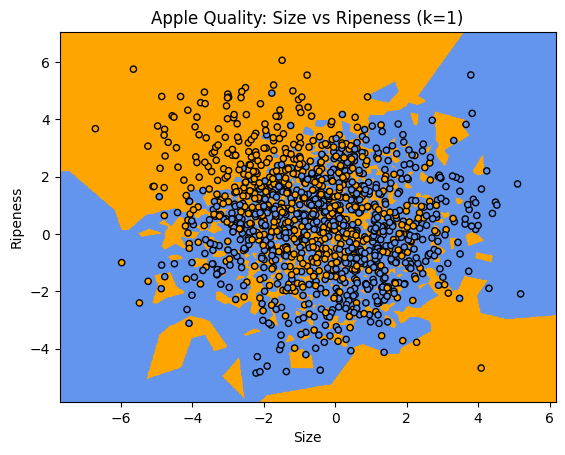

Accuracy (K = 1) : 0.62


In [ ]:
# Decision Boundary with best 2 features and k=1
print(f"Student ID: 65010421 → k = {student_k}")
print(f"Best features: {best_features[0]} + {best_features[1]}")
print(f"Expected accuracy with 2 features: {best_feature_accuracy:.4f}")
print()

# Plot the decision boundary using best features with k=1
final_accuracy = plot_apple_knn_two_feature_regions(
    X_apple, y_apple, 
    best_features[0], best_features[1], 
    n_neighbors=student_k
)